# Modelling and Evaluation Notebook

### Objectives

Accomplish the second business requirement:The customer wants to be able to know whether a cherry leaf is healthy or contains powdery mildew. 

### Inputs

+ inputs/cherry_leaves_dataset/cherry_leaves_image/train
+ inputs/cherry_leaves_dataset/cherry_leaves_image/test
+ inputs/cherry_leaves_dataset/cherry_leaves_image/validation
+ Image shape.

### Outputs

+ Distribution plot of images in the train, validation, and test sets.
+ Image augmentation.
+ Class indices to change prediction inference in labels.
+ Machine learning model creation and training.
+ Save model.
+ Learning curve plot for model performance.
+ Model evaluation on pickle file.
+ Prediction on the random image file.

# Import the required packages

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set Working Directory

In [12]:
cwd= os.getcwd()

In [13]:
os.chdir('/workspaces/mildew-detector')
print("'mildew-detector' has been set as the new current directory")

'mildew-detector' has been set as the new current directory


In [14]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

# Set input directories

+ Set train, validation and test paths.

In [15]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry_leaves_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directory

In [16]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set labels

In [17]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


# Set image shape

In [18]:
## Import saved image shape
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

# Survey and plot the number of images in the train, test, and validation data sets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




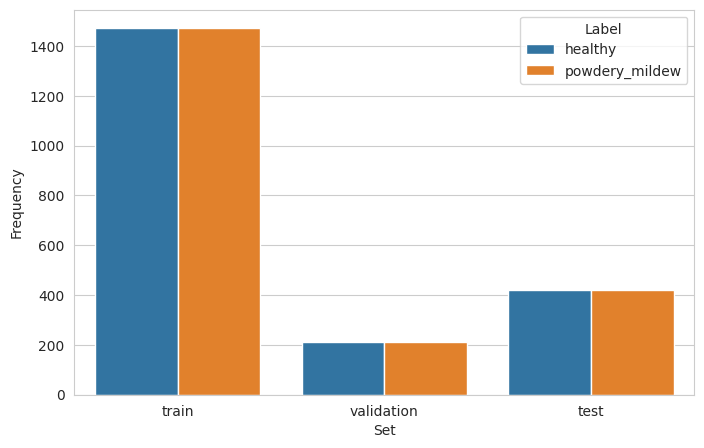

In [19]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Image data augmentation

### ImageDataGenerator

+ Import ImageDataGenerator

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

+ Initialize ImageDataGenerator

In [21]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment images datasets

+ Augment training image dataset

In [22]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

+ Augment validation image dataset

In [23]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

+ Augment test image dataset

In [24]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented images

+ Plot augmented training images

(20, 100, 100, 3)


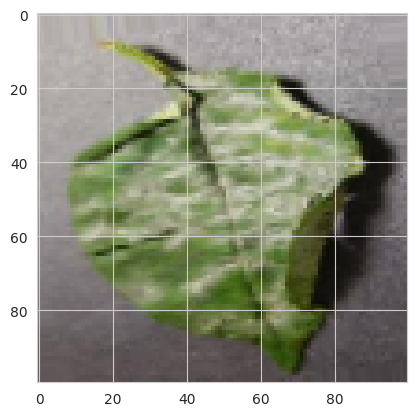

(20, 100, 100, 3)


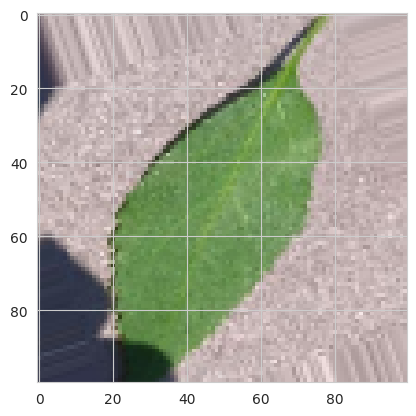

(20, 100, 100, 3)


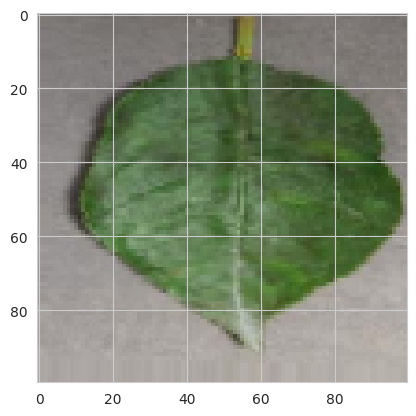

In [25]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

+ Plot augmented validation images

(20, 100, 100, 3)


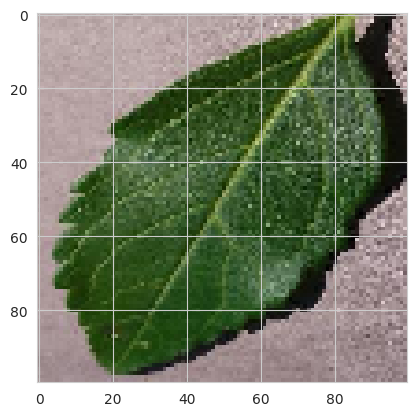

(20, 100, 100, 3)


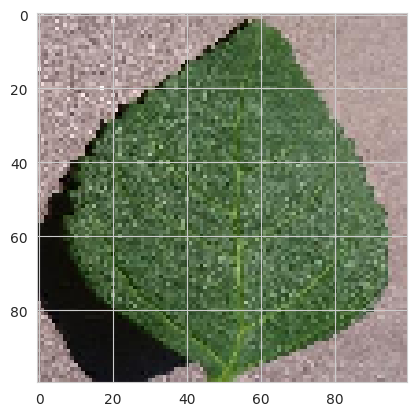

(20, 100, 100, 3)


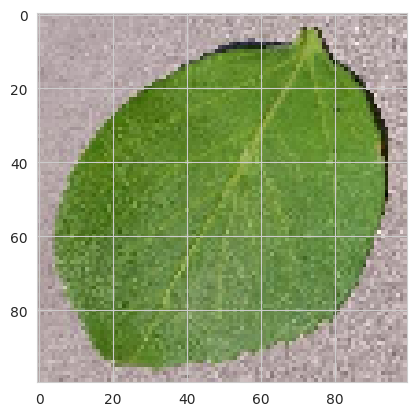

In [26]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

+ Plot augmented test images

(20, 100, 100, 3)


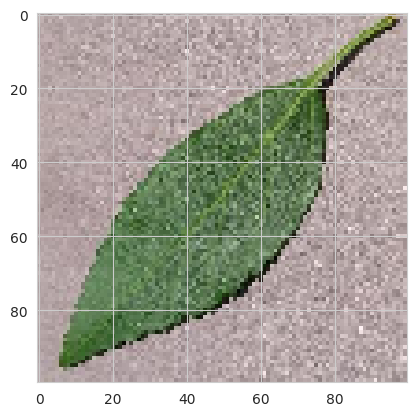

(20, 100, 100, 3)


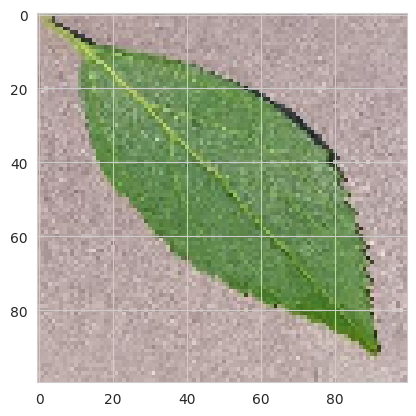

(20, 100, 100, 3)


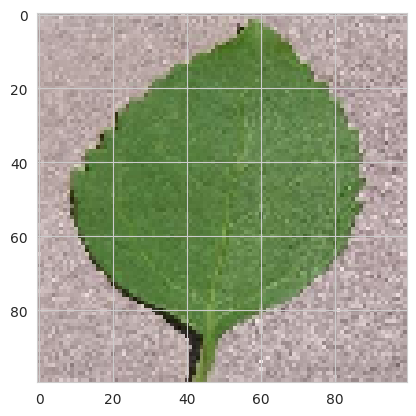

In [27]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [28]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

# Model creation

### ML model

+ Import model packages

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

+ Model

In [30]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

+ Model Summary

In [31]:
create_tf_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)             

+ Early Stopping

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [33]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-01-12 05:17:48.481181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 124s 416ms/step - loss: 0.2948 - accuracy: 0.8649 - val_loss: 0.0766 - val_accuracy: 0.9833
Epoch 2/25
147/147 [==============================] - 60s 405ms/step - loss: 0.0855 - accuracy: 0.9720 - val_loss: 0.0163 - val_accuracy: 0.9929
Epoch 3/25
147/147 [==============================] - 60s 406ms/step - loss: 0.0397 - accuracy: 0.9884 - val_loss: 0.0104 - val_accuracy: 0.9952
Epoch 4/25
147/147 [==============================] - 59s 403ms/step - loss: 0.0454 - accuracy: 0.9891 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 5/25
147/147 [==============================] - 54s 364ms/step - loss: 0.0307 - accuracy: 0.9935 - val_loss: 0.0112 - val_accuracy: 0.9976
Epoch 6/25
147/147 [==============================] - 55s 376ms/step - loss: 0.0328 - accuracy: 0.9915 - val_loss: 0.0087 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 53s 363ms/step - loss: 0.0237 - accuracy: 0.9938 - val_loss: 0.0024 - val_a

### Save model

In [34]:
model.save('outputs/v1/mildew_detector_model.h5')

# Model Performace

### Model learning curve

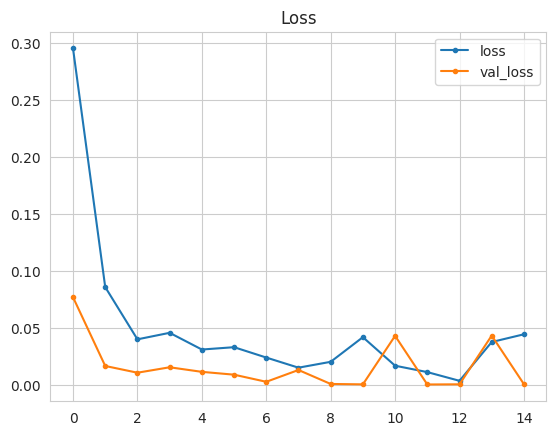

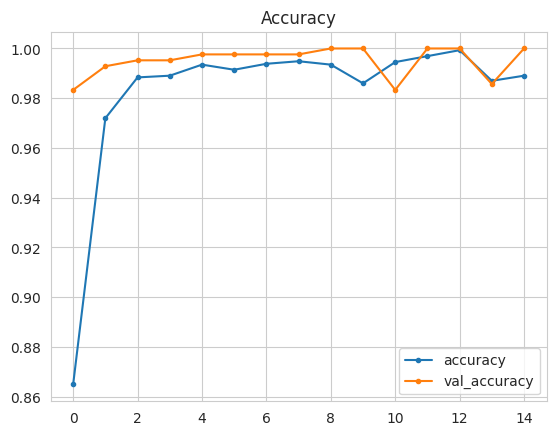

In [35]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

+ Load saved model

In [37]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

+ Evaluate model on test set

In [38]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 5s 113ms/step - loss: 0.0038 - accuracy: 0.9976


+ Save evaluation pickle

In [39]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data

+ Load a random image as PIL

Image shape: (100, 100), Image mode: RGB


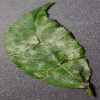

In [43]:
from tensorflow.keras.preprocessing import image

pointer = 49
label = labels[1]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

+ Convert image to array and prepare for prediction

In [44]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


+ Predict class probabilities

In [45]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1.0
powdery_mildew


# Push files to Repo

### Push the files generated in this session to my GitHub mildew-detector repository

+ .gitignore

In [46]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

+ Git status

In [47]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/03 - Modelling and Evaluating.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	outputs/v1/evaluation.pkl
	outputs/v1/model_training_acc.png
	outputs/v1/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


+ Git add

In [49]:
!git add .

+ Git commit

In [50]:
!git commit -am " Add new files and plots"

[main a87bb00]  Add new files and plots
 4 files changed, 345 insertions(+), 16 deletions(-)
 create mode 100644 outputs/v1/evaluation.pkl
 create mode 100644 outputs/v1/model_training_acc.png
 create mode 100644 outputs/v1/model_training_losses.png


+ Git push

In [51]:
!git push

Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 4 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (9/9), 162.16 KiB | 2.42 MiB/s, done.
Total 9 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/Majdi-Aref/mildew-detector
   9cd0df7..a87bb00  main -> main
